In [1]:
%matplotlib inline

In [2]:
import os
import math
import matplotlib.pyplot as plt
import polars as pl
import numpy as np
import seaborn as sns
from pathlib import Path

import coola
from coola.utils import str_mapping, repr_mapping

In [3]:
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (16, 5)

In [4]:
from arctix.dataset.breakfast import Column, fetch_data, prepare_data, group_by_sequence, to_array
from arctix.utils.masking import convert_sequences_to_array, generate_mask_from_lengths

In [5]:
# Define the path where to store/load the raw data
data_path = Path(os.environ['ARCTIX_DATA_PATH']).joinpath("breakfast")

## Load raw data

You can use the function `arctix.dataset.breakfast.fetch_data` to load the raw data in a `polars.DataFrame` format. 
Note that if the data was not downloaded in the dataset path, the `fetch_data` function automatically downloads the data. 

In [6]:
data_raw = fetch_data(data_path, "segmentation_coarse")
data_raw

action,start_time,end_time,person,cooking_activity
str,f64,f64,str,str
"""SIL""",1.0,30.0,"""P03""","""cereals"""
"""take_bowl""",31.0,150.0,"""P03""","""cereals"""
"""pour_cereals""",151.0,428.0,"""P03""","""cereals"""
"""pour_milk""",429.0,575.0,"""P03""","""cereals"""
"""stir_cereals""",576.0,705.0,"""P03""","""cereals"""
…,…,…,…,…
"""take_cup""",38.0,92.0,"""P54""","""tea"""
"""pour_water""",93.0,229.0,"""P54""","""tea"""
"""add_teabag""",230.0,744.0,"""P54""","""tea"""


In [7]:
data_raw.describe()

statistic,action,start_time,end_time,person,cooking_activity
str,str,f64,f64,str,str
"""count""","""3585""",3585.0,3585.0,"""3585""","""3585"""
"""null_count""","""0""",0.0,0.0,"""0""","""0"""
"""mean""",null,1128.588285,1433.142817,null,null
"""std""",null,1462.868314,1578.260199,null,null
"""min""","""SIL""",1.0,0.0,"""P03""","""cereals"""
"""25%""",null,75.0,314.0,null,null
"""50%""",null,569.0,884.0,null,null
"""75%""",null,1623.0,2071.0,null,null
"""max""","""take_topping""",9681.0,9745.0,"""P54""","""tea"""


## Analyze raw data

In [8]:
group_len = data_raw.group_by([Column.PERSON, Column.COOKING_ACTIVITY]).len()
group_len

person,cooking_activity,len
str,str,u32
"""P14""","""milk""",6
"""P06""","""cereals""",5
"""P25""","""milk""",6
"""P23""","""coffee""",5
"""P27""","""juice""",6
…,…,…
"""P54""","""coffee""",7
"""P22""","""coffee""",3
"""P21""","""juice""",6


min=3  max=25  nbins=23


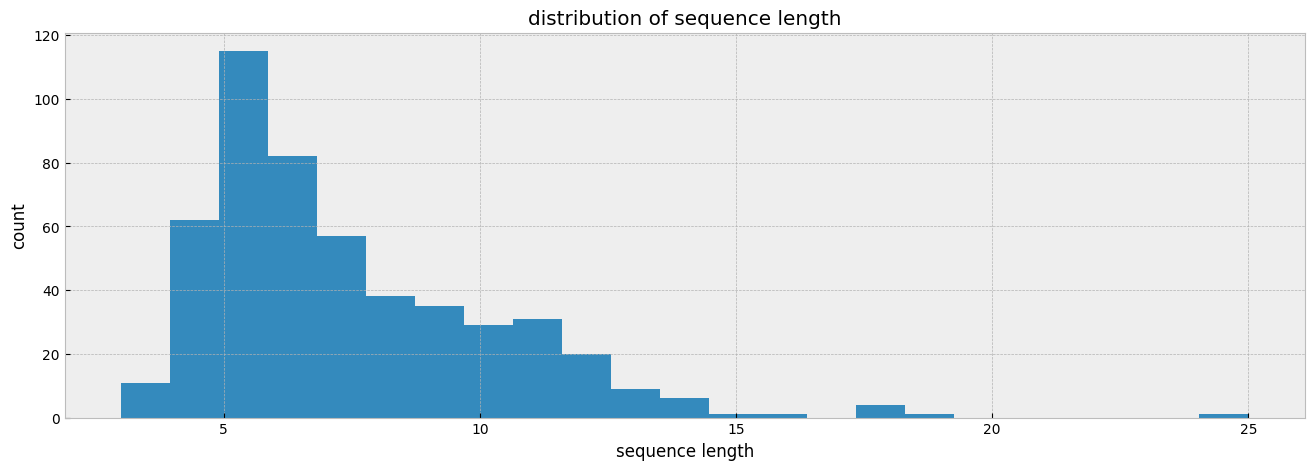

In [9]:
max_len = group_len.select(pl.col('len')).max().item()
min_len = group_len.select(pl.col('len')).min().item()
nbins = max_len - min_len + 1
print(f'min={min_len}  max={max_len}  nbins={nbins}')

fig, ax = plt.subplots()
_ = ax.hist(group_len.select(pl.col('len')), bins=nbins, range=[min_len, max_len])

_ = ax.set_title('distribution of sequence length')
_ = ax.set_xlabel('sequence length')
_ = ax.set_ylabel('count')

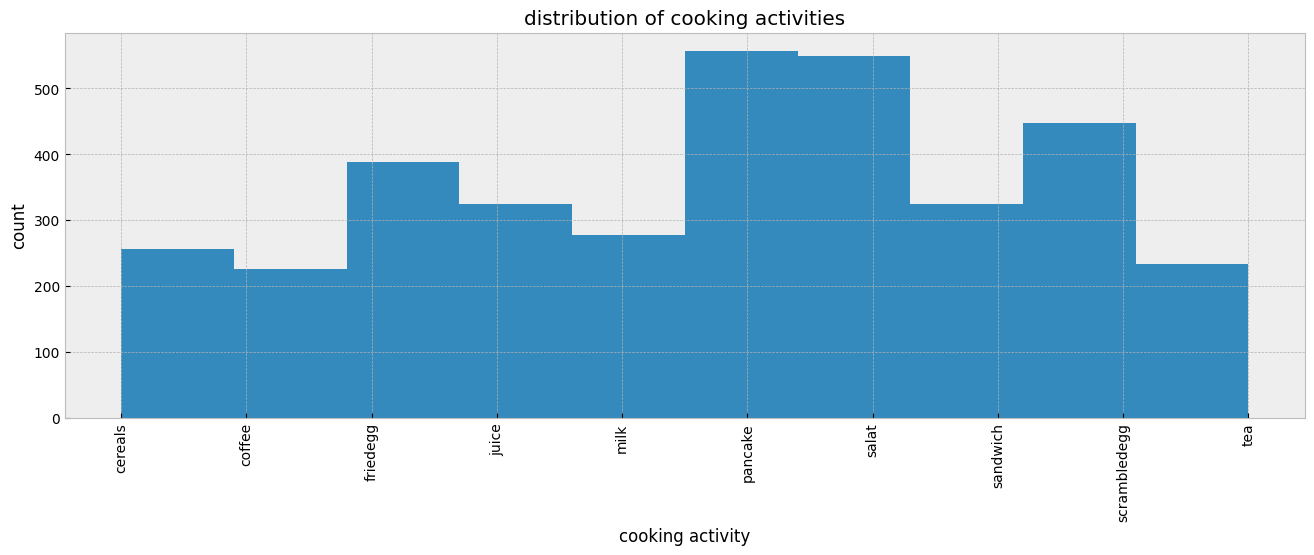

In [10]:
num_activities = data_raw.select(pl.col(Column.COOKING_ACTIVITY)).n_unique()
fig, ax = plt.subplots()
_ = ax.hist(data_raw.select(pl.col(Column.COOKING_ACTIVITY)), bins=num_activities)

_ = ax.set_title('distribution of cooking activities')
_ = ax.set_xlabel('cooking activity')
_ = ax.set_ylabel('count')
_ = ax.tick_params(axis="x", labelrotation=90)

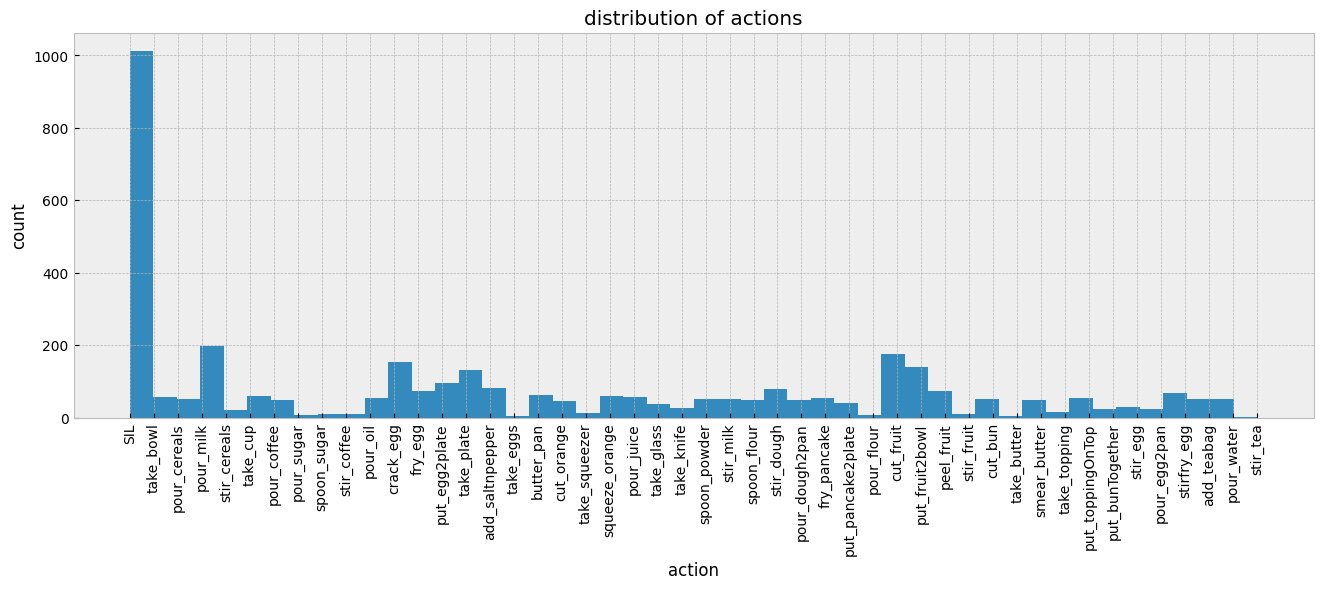

In [11]:
num_actions = data_raw.select(pl.col(Column.ACTION)).n_unique()
fig, ax = plt.subplots()
_ = ax.hist(data_raw.select(pl.col(Column.ACTION)), bins=num_actions)

_ = ax.set_title('distribution of actions')
_ = ax.set_xlabel('action')
_ = ax.set_ylabel('count')
_ = ax.tick_params(axis="x", labelrotation=90)

## Prepare data

In [12]:
data, metadata = prepare_data(data_raw)
data

stripping chars: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 991.01it/s]


action,start_time,end_time,person,cooking_activity,action_id,person_id,cooking_activity_id
str,f32,f32,str,str,i64,i64,i64
"""SIL""",1.0,30.0,"""P03""","""cereals""",0,50,7
"""take_bowl""",31.0,150.0,"""P03""","""cereals""",16,50,7
"""pour_cereals""",151.0,428.0,"""P03""","""cereals""",21,50,7
"""pour_milk""",429.0,575.0,"""P03""","""cereals""",1,50,7
"""stir_cereals""",576.0,705.0,"""P03""","""cereals""",37,50,7
…,…,…,…,…,…,…,…
"""take_cup""",38.0,92.0,"""P54""","""tea""",13,12,8
"""pour_water""",93.0,229.0,"""P54""","""tea""",23,12,8
"""add_teabag""",230.0,744.0,"""P54""","""tea""",25,12,8


In [13]:
print(str_mapping(metadata))

(vocab_action): Vocabulary(vocab_size=48)
(vocab_activity): Vocabulary(vocab_size=10)
(vocab_person): Vocabulary(vocab_size=52)


In [14]:
arrays = to_array(data)
print(coola.summary(arrays))
print(str_mapping(arrays))

<class 'dict'> (length=6)
  (sequence_length): <class 'numpy.ndarray'> | shape=(503,) | dtype=int64
  (person_id): <class 'numpy.ndarray'> | shape=(503,) | dtype=int64
  (cooking_activity_id): <class 'numpy.ndarray'> | shape=(503,) | dtype=int64
  (action_id): <class 'numpy.ma.core.MaskedArray'> | shape=(503, 25) | dtype=int64
  (start_time): <class 'numpy.ma.core.MaskedArray'> | shape=(503, 25) | dtype=float64
  ...
(sequence_length): [11 19 10  8  6  8  6  5  5  6 11 25  9  6  6  5  7  4  5  5 10 12 10  9
    9  9  7  6  5  6 12  9 13 11  7 12  6  4  4  4 12 11 12  9  6  6  7  6
    5  7 14 18  8  9  7  7  5  5  4  4 11 18 11  7  9  8  5  6  5 12 11  9
    8  5  8  7  5  6  6 12  9 11  5  7  6  6  6  7  7 11 18 10  8  5  6  5
    5  4  4 14  5  9 10  7  7  6  6  5  7  9 13 11  8  5 13  5  5  4  3 12
   12 11  7  6  5  4  5  6  7 12 14 10  9  6  7  6  4  4  3 10 10  8  8  6
   12  5  5  5  5 18 11  7  7  6  6  5  5  4  4 16  6 11  7  6  8  5  5  4
    5 13  9 11  8  5  6  5  6  5  5  